# Fully Connected Neural Network

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)


In [2]:
def f(x, t):
    return (1 - 16  * np.pi**2) * np.sin(x) * np.cos(4 * np.pi * t)

def u(x, t):
    return np.sin(x) * np.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = np.random.rand(n) * L
    t_vals = np.random.rand(n) * t_end
    return (x_vals, t_vals, f(x_vals, t_vals), u(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
bias_train = torch.ones_like(x_norm)  # Bias column of ones
bias_val = torch.ones_like(x_val_norm)
inputs_train = torch.stack([x_norm, t_norm, bias_train], dim=1)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm, bias_val], dim=1)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1)  # Shape: [N_val, 2]

batch_size = 300
training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [7]:
device = torch.device("cpu")
print("Device: ", device)

Device:  cpu


In [8]:
class FNN(nn.Module):
    # We create FNN as a subclass of nn.Module
    # In this way we import some important methods from the parent class
    def __init__(self, input_size, output_size, hidden_features=64, activation_function=nn.ReLU()):
        super().__init__()
        
        self.activation_function = activation_function
        # In the init method we specify the layers of the neural network
        # ---------------------- student exercise --------------------------------- #
        self.linear_layer_1 = nn.Linear(
            in_features=input_size, out_features=hidden_features, bias=True
        )

        self.linear_layer_2 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_3 = nn.Linear(
            in_features=hidden_features, out_features=hidden_features, bias=True
        )

        self.linear_layer_4 = nn.Linear(
            in_features=hidden_features, out_features=output_size, bias=True
        )
    
        # ---------------------- student exercise --------------------------------- #

    def forward(self, x):
        # The FNN takes a flatten input of dimensions [N, F],
        # where N are the samples and F are the input features (input_size)
        # x is already shaped as [batch_size, 2] from the DataLoader

        # ---------------------- student exercise --------------------------------- #
        x = self.linear_layer_1(x)
        x = self.activation_function(x)
        x = self.linear_layer_2(x)
        x = self.activation_function(x)
        x = self.linear_layer_3(x)
        x = self.activation_function(x)
        x = self.linear_layer_4(x)
        # ---------------------- student exercise --------------------------------- #

        return x

In [9]:
input_size = 3  # x, t, bias
output_size = 2  # f, u;

print(f"The size of input will be = {input_size}")
print(f"The size of output will be = {output_size}")

model = FNN(input_size, output_size, hidden_features=128)
print(model)

The size of input will be = 3
The size of output will be = 2
FNN(
  (activation_function): ReLU()
  (linear_layer_1): Linear(in_features=3, out_features=128, bias=True)
  (linear_layer_2): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=128, bias=True)
  (linear_layer_4): Linear(in_features=128, out_features=2, bias=True)
)


In [10]:
model = model.to(device)

In [11]:
batch_size = 128
loss_function = nn.L1Loss()

In [12]:
def train_epoch(model, loader, optimizer, loss_function):
    model.train()  # specifies that the model is in training mode
    losses = []

    for batch in loader:
        inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]

        # 1. Model prediction
        pred = model(inputs)

        # 2. Loss function
        loss = loss_function(pred, target)

        # 3. Append the loss to a list of losses for later analysis. Hint: Use `detach()` and `item()` to extract the loss value from the loss tensor.
        losses.append(loss.detach().item())

        # 4. Backpropagate. Hint: Use the method .backward() to compute the gradients.
        loss.backward()

        # 5. Optimize the weights with the optimizer Hint: Use the method .step() to update the weights.
        optimizer.step()

        # 6. Reset the computed gradients. Hint: Use the method .zero_grad() to reset the gradients.
        optimizer.zero_grad(set_to_none=True)

    return np.array(losses).mean()

In [13]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [14]:
import optuna

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "SGD"])
    optimizer_cls = {
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "SGD": torch.optim.SGD,
    }[optimizer_name]

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    activation_name = trial.suggest_categorical("activation", ["ReLU", "Tanh", "SiLU", "ELU"])
    activation_obj = {
        "ReLU": nn.ReLU(),
        "Tanh": nn.Tanh(),
        "SiLU": nn.SiLU(),
        "ELU": nn.ELU(),
    }[activation_name]

    loss_name = trial.suggest_categorical("loss", ["L1", "MSE"])
    loss_function = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}[loss_name]

    model = FNN(input_size, output_size, hidden_features=hidden_size, activation_function=activation_obj)
    model = model.to(device)

    optimizer = optimizer_cls(model.parameters(), lr=learning_rate)

    # epochs to use during tuning; override by setting NUM_EPOCHS_TUNE earlier
    num_epochs = int(globals().get("NUM_EPOCHS_TUNE", 50))

    best_val = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, loss_function)
        validation_loss = evaluation(model, validation_loader, loss_function)
        
        if validation_loss < best_val:
            best_val = validation_loss

        # report intermediate result to Optuna and allow pruning
        trial.report(validation_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        if epoch % 10 == 0:
            print(
                "epoch:",
                epoch,
                "\t training loss:",
                np.round(train_loss, 4),
                "\t validation loss:",
                np.round(validation_loss, 4),
            )

    # minimize best validation loss across epochs
    return best_val

In [15]:
# Tuning configuration (adjust as desired)
NUM_EPOCHS_TUNE = 100   # epochs per trial
N_TRIALS = 20          # number of trials

sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

study = optuna.create_study(
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
    study_name="fnn_tuning"
)

study.optimize(objective, n_trials=N_TRIALS)

print("Best value:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-09 12:25:17,983] A new study created in memory with name: fnn_tuning


epoch: 10 	 training loss: 0.8039 	 validation loss: 0.8286
epoch: 20 	 training loss: 0.7981 	 validation loss: 0.8222
epoch: 30 	 training loss: 0.791 	 validation loss: 0.8149
epoch: 40 	 training loss: 0.7866 	 validation loss: 0.8112
epoch: 50 	 training loss: 0.7831 	 validation loss: 0.808
epoch: 60 	 training loss: 0.7792 	 validation loss: 0.8045
epoch: 70 	 training loss: 0.7746 	 validation loss: 0.7995
epoch: 80 	 training loss: 0.7677 	 validation loss: 0.7916
epoch: 90 	 training loss: 0.7518 	 validation loss: 0.7732


[I 2026-01-09 12:26:11,395] Trial 0 finished with value: 0.7002818733453751 and parameters: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 4.207988669606632e-05, 'activation': 'SiLU', 'loss': 'L1'}. Best is trial 0 with value: 0.7002818733453751.


epoch: 100 	 training loss: 0.6904 	 validation loss: 0.7003
epoch: 10 	 training loss: 0.8017 	 validation loss: 0.825
epoch: 20 	 training loss: 0.7938 	 validation loss: 0.8163
epoch: 30 	 training loss: 0.7869 	 validation loss: 0.8076
epoch: 40 	 training loss: 0.7339 	 validation loss: 0.7452
epoch: 50 	 training loss: 0.5371 	 validation loss: 0.5414
epoch: 60 	 training loss: 0.2638 	 validation loss: 0.2576
epoch: 70 	 training loss: 0.1116 	 validation loss: 0.1069
epoch: 80 	 training loss: 0.0813 	 validation loss: 0.0783
epoch: 90 	 training loss: 0.0686 	 validation loss: 0.0669


[I 2026-01-09 12:27:09,223] Trial 1 finished with value: 0.056577639654278755 and parameters: {'hidden_size': 256, 'optimizer': 'AdamW', 'learning_rate': 5.415244119402538e-05, 'activation': 'Tanh', 'loss': 'L1'}. Best is trial 1 with value: 0.056577639654278755.


epoch: 100 	 training loss: 0.0585 	 validation loss: 0.0591
epoch: 10 	 training loss: 0.8096 	 validation loss: 0.834
epoch: 20 	 training loss: 0.8093 	 validation loss: 0.8338
epoch: 30 	 training loss: 0.809 	 validation loss: 0.8335
epoch: 40 	 training loss: 0.8088 	 validation loss: 0.8333
epoch: 50 	 training loss: 0.8086 	 validation loss: 0.8331
epoch: 60 	 training loss: 0.8084 	 validation loss: 0.8329
epoch: 70 	 training loss: 0.8082 	 validation loss: 0.8328
epoch: 80 	 training loss: 0.808 	 validation loss: 0.8326
epoch: 90 	 training loss: 0.8078 	 validation loss: 0.8325


[I 2026-01-09 12:27:51,902] Trial 2 finished with value: 0.8323688358068466 and parameters: {'hidden_size': 96, 'optimizer': 'SGD', 'learning_rate': 6.290644294586152e-05, 'activation': 'ELU', 'loss': 'L1'}. Best is trial 1 with value: 0.056577639654278755.


epoch: 100 	 training loss: 0.8077 	 validation loss: 0.8324
epoch: 10 	 training loss: 0.8511 	 validation loss: 0.8715
epoch: 20 	 training loss: 0.3057 	 validation loss: 0.2903
epoch: 30 	 training loss: 0.0509 	 validation loss: 0.0471
epoch: 40 	 training loss: 0.016 	 validation loss: 0.0151
epoch: 50 	 training loss: 0.0101 	 validation loss: 0.0096
epoch: 60 	 training loss: 0.0072 	 validation loss: 0.0069
epoch: 70 	 training loss: 0.0056 	 validation loss: 0.0053
epoch: 80 	 training loss: 0.0044 	 validation loss: 0.0043
epoch: 90 	 training loss: 0.0035 	 validation loss: 0.0034


[I 2026-01-09 12:28:47,480] Trial 3 finished with value: 0.002705403428990394 and parameters: {'hidden_size': 256, 'optimizer': 'AdamW', 'learning_rate': 2.458603276328006e-05, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 3 with value: 0.002705403428990394.


epoch: 100 	 training loss: 0.0028 	 validation loss: 0.0027
epoch: 10 	 training loss: 0.1077 	 validation loss: 0.1255
epoch: 20 	 training loss: 0.0457 	 validation loss: 0.0523
epoch: 30 	 training loss: 0.049 	 validation loss: 0.0479
epoch: 40 	 training loss: 0.0397 	 validation loss: 0.0473
epoch: 50 	 training loss: 0.0352 	 validation loss: 0.0453
epoch: 60 	 training loss: 0.0379 	 validation loss: 0.0433
epoch: 70 	 training loss: 0.0399 	 validation loss: 0.0343
epoch: 80 	 training loss: 0.0304 	 validation loss: 0.031
epoch: 90 	 training loss: 0.0304 	 validation loss: 0.0354


[I 2026-01-09 12:29:34,074] Trial 4 finished with value: 0.02169072814285755 and parameters: {'hidden_size': 96, 'optimizer': 'AdamW', 'learning_rate': 0.0015375920235481753, 'activation': 'Tanh', 'loss': 'L1'}. Best is trial 3 with value: 0.002705403428990394.


epoch: 100 	 training loss: 0.0291 	 validation loss: 0.0251


[I 2026-01-09 12:29:37,013] Trial 5 pruned. 
[I 2026-01-09 12:29:39,016] Trial 6 pruned. 
[I 2026-01-09 12:29:41,289] Trial 7 pruned. 
[I 2026-01-09 12:29:44,451] Trial 8 pruned. 


epoch: 10 	 training loss: 0.0836 	 validation loss: 0.0764
epoch: 20 	 training loss: 0.0447 	 validation loss: 0.0488
epoch: 30 	 training loss: 0.0253 	 validation loss: 0.0245
epoch: 40 	 training loss: 0.0196 	 validation loss: 0.0202
epoch: 50 	 training loss: 0.0185 	 validation loss: 0.0179
epoch: 60 	 training loss: 0.0187 	 validation loss: 0.0191
epoch: 70 	 training loss: 0.0188 	 validation loss: 0.0152
epoch: 80 	 training loss: 0.0159 	 validation loss: 0.0169
epoch: 90 	 training loss: 0.0153 	 validation loss: 0.0146


[I 2026-01-09 12:30:39,346] Trial 9 finished with value: 0.01416075392626226 and parameters: {'hidden_size': 32, 'optimizer': 'Adam', 'learning_rate': 0.0010821382910613986, 'activation': 'ReLU', 'loss': 'L1'}. Best is trial 3 with value: 0.002705403428990394.


epoch: 100 	 training loss: 0.0189 	 validation loss: 0.0283


[I 2026-01-09 12:30:42,563] Trial 10 pruned. 


epoch: 10 	 training loss: 0.0098 	 validation loss: 0.0086
epoch: 20 	 training loss: 0.0038 	 validation loss: 0.0034
epoch: 30 	 training loss: 0.0019 	 validation loss: 0.0018
epoch: 40 	 training loss: 0.0012 	 validation loss: 0.001
epoch: 50 	 training loss: 0.0007 	 validation loss: 0.0007
epoch: 60 	 training loss: 0.0005 	 validation loss: 0.0007
epoch: 70 	 training loss: 0.0003 	 validation loss: 0.0005
epoch: 80 	 training loss: 0.0004 	 validation loss: 0.0003
epoch: 90 	 training loss: 0.0002 	 validation loss: 0.0003


[I 2026-01-09 12:32:16,041] Trial 11 finished with value: 0.00022813012401456945 and parameters: {'hidden_size': 160, 'optimizer': 'Adam', 'learning_rate': 0.00037137406244381347, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 11 with value: 0.00022813012401456945.


epoch: 100 	 training loss: 0.0004 	 validation loss: 0.0006
epoch: 10 	 training loss: 0.0076 	 validation loss: 0.0064
epoch: 20 	 training loss: 0.0013 	 validation loss: 0.0012
epoch: 30 	 training loss: 0.0005 	 validation loss: 0.0005
epoch: 40 	 training loss: 0.0004 	 validation loss: 0.0004
epoch: 50 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 60 	 training loss: 0.0003 	 validation loss: 0.0003
epoch: 70 	 training loss: 0.0003 	 validation loss: 0.0004
epoch: 80 	 training loss: 0.0002 	 validation loss: 0.0004
epoch: 90 	 training loss: 0.0002 	 validation loss: 0.0003


[I 2026-01-09 12:33:56,136] Trial 12 finished with value: 0.00018209337213193066 and parameters: {'hidden_size': 192, 'optimizer': 'Adam', 'learning_rate': 0.0002518075412501645, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 12 with value: 0.00018209337213193066.


epoch: 100 	 training loss: 0.0002 	 validation loss: 0.0003
epoch: 10 	 training loss: 0.0098 	 validation loss: 0.0088
epoch: 20 	 training loss: 0.003 	 validation loss: 0.0029
epoch: 30 	 training loss: 0.0011 	 validation loss: 0.0011
epoch: 40 	 training loss: 0.0005 	 validation loss: 0.0006
epoch: 50 	 training loss: 0.0003 	 validation loss: 0.0002
epoch: 60 	 training loss: 0.0002 	 validation loss: 0.0003
epoch: 70 	 training loss: 0.0003 	 validation loss: 0.0005
epoch: 80 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 90 	 training loss: 0.0001 	 validation loss: 0.0001


[I 2026-01-09 12:36:00,015] Trial 13 finished with value: 8.405140397371724e-05 and parameters: {'hidden_size': 192, 'optimizer': 'Adam', 'learning_rate': 0.0002710062862900652, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 8.405140397371724e-05.


epoch: 100 	 training loss: 0.0002 	 validation loss: 0.0001


[I 2026-01-09 12:36:08,270] Trial 14 pruned. 


epoch: 10 	 training loss: 0.0122 	 validation loss: 0.0099
epoch: 20 	 training loss: 0.0031 	 validation loss: 0.0026
epoch: 30 	 training loss: 0.0009 	 validation loss: 0.0008
epoch: 40 	 training loss: 0.0004 	 validation loss: 0.0004
epoch: 50 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 60 	 training loss: 0.0002 	 validation loss: 0.0004
epoch: 70 	 training loss: 0.0002 	 validation loss: 0.0003
epoch: 80 	 training loss: 0.0001 	 validation loss: 0.0002
epoch: 90 	 training loss: 0.0001 	 validation loss: 0.0001


[I 2026-01-09 12:37:54,127] Trial 15 finished with value: 9.153000246442389e-05 and parameters: {'hidden_size': 192, 'optimizer': 'Adam', 'learning_rate': 0.00023506997063237178, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 8.405140397371724e-05.


epoch: 100 	 training loss: 0.0001 	 validation loss: 0.0002
epoch: 10 	 training loss: 0.0237 	 validation loss: 0.0189
epoch: 20 	 training loss: 0.0066 	 validation loss: 0.0059
epoch: 30 	 training loss: 0.0035 	 validation loss: 0.0032
epoch: 40 	 training loss: 0.002 	 validation loss: 0.0019
epoch: 50 	 training loss: 0.0012 	 validation loss: 0.0011
epoch: 60 	 training loss: 0.0008 	 validation loss: 0.0008
epoch: 70 	 training loss: 0.0005 	 validation loss: 0.0005
epoch: 80 	 training loss: 0.0004 	 validation loss: 0.0004
epoch: 90 	 training loss: 0.0003 	 validation loss: 0.0003


[I 2026-01-09 12:39:24,039] Trial 16 finished with value: 0.0002033305645454675 and parameters: {'hidden_size': 160, 'optimizer': 'Adam', 'learning_rate': 0.00015186433030007555, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 13 with value: 8.405140397371724e-05.


epoch: 100 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 10 	 training loss: 0.0039 	 validation loss: 0.0036
epoch: 20 	 training loss: 0.0008 	 validation loss: 0.0006
epoch: 30 	 training loss: 0.0005 	 validation loss: 0.0002
epoch: 40 	 training loss: 0.0022 	 validation loss: 0.0039
epoch: 50 	 training loss: 0.0001 	 validation loss: 0.0002
epoch: 60 	 training loss: 0.0004 	 validation loss: 0.0012
epoch: 70 	 training loss: 0.0007 	 validation loss: 0.002
epoch: 80 	 training loss: 0.0003 	 validation loss: 0.0001
epoch: 90 	 training loss: 0.0003 	 validation loss: 0.0004


[I 2026-01-09 12:40:57,893] Trial 17 finished with value: 4.8554242312093265e-05 and parameters: {'hidden_size': 224, 'optimizer': 'Adam', 'learning_rate': 0.0006228121955892882, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 17 with value: 4.8554242312093265e-05.


epoch: 100 	 training loss: 0.0001 	 validation loss: 0.0
epoch: 10 	 training loss: 0.0081 	 validation loss: 0.0065
epoch: 20 	 training loss: 0.0021 	 validation loss: 0.0005
epoch: 30 	 training loss: 0.0017 	 validation loss: 0.0025
epoch: 40 	 training loss: 0.0083 	 validation loss: 0.0166
epoch: 50 	 training loss: 0.0027 	 validation loss: 0.0005
epoch: 60 	 training loss: 0.0003 	 validation loss: 0.0008
epoch: 70 	 training loss: 0.0006 	 validation loss: 0.0018
epoch: 80 	 training loss: 0.0064 	 validation loss: 0.005
epoch: 90 	 training loss: 0.0012 	 validation loss: 0.0007


[I 2026-01-09 12:42:20,670] Trial 18 finished with value: 9.766795483301394e-05 and parameters: {'hidden_size': 224, 'optimizer': 'Adam', 'learning_rate': 0.003161919883557652, 'activation': 'ELU', 'loss': 'MSE'}. Best is trial 17 with value: 4.8554242312093265e-05.


epoch: 100 	 training loss: 0.0004 	 validation loss: 0.0009
epoch: 10 	 training loss: 0.0048 	 validation loss: 0.0049
epoch: 20 	 training loss: 0.0008 	 validation loss: 0.0008
epoch: 30 	 training loss: 0.0006 	 validation loss: 0.0006
epoch: 40 	 training loss: 0.0003 	 validation loss: 0.0002
epoch: 50 	 training loss: 0.0002 	 validation loss: 0.0002
epoch: 60 	 training loss: 0.0001 	 validation loss: 0.0002
epoch: 70 	 training loss: 0.0007 	 validation loss: 0.0009
epoch: 80 	 training loss: 0.0005 	 validation loss: 0.0003
epoch: 90 	 training loss: 0.0012 	 validation loss: 0.0021


[I 2026-01-09 12:43:17,986] Trial 19 finished with value: 4.766055462823715e-05 and parameters: {'hidden_size': 224, 'optimizer': 'Adam', 'learning_rate': 0.0006025760834309505, 'activation': 'ReLU', 'loss': 'MSE'}. Best is trial 19 with value: 4.766055462823715e-05.


epoch: 100 	 training loss: 0.0013 	 validation loss: 0.0003
Best value: 4.766055462823715e-05
Best params: {'hidden_size': 224, 'optimizer': 'Adam', 'learning_rate': 0.0006025760834309505, 'activation': 'ReLU', 'loss': 'MSE'}


In [16]:
# Optuna visualization: interactive plots + optional HTML export
# Run this AFTER the study optimization cell.

# Ensure visualization dependencies
try:
    from optuna import visualization as vis
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna", "plotly"])  # install if missing
    from optuna import visualization as vis

if "study" not in globals():
    raise RuntimeError("Optuna study not found. Run the tuning cell first.")

# Build figures
figs = [
    ("Optimization History", vis.plot_optimization_history(study)),
    ("Parallel Coordinate", vis.plot_parallel_coordinate(study)),
    ("Slice", vis.plot_slice(study)),
    ("Contour", vis.plot_contour(study)),
    ("Param Importances", vis.plot_param_importances(study)),
    ("EDF", vis.plot_edf(study)),
]

# Show interactively in the notebook
for title, fig in figs:
    fig.update_layout(title=title)
    fig.show()

# Optional: save to HTML under output/plots
import os
from datetime import datetime
import plotly.io as pio
save_dir = os.path.join("output", "plots")
os.makedirs(save_dir, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
for title, fig in figs:
    filename = os.path.join(save_dir, f"optuna_{title.lower().replace(' ', '_')}_{ts}.html")
    pio.write_html(fig, file=filename, include_plotlyjs="cdn")
print(f"Saved {len(figs)} figures to {save_dir}")

Saved 6 figures to output\plots


Using best params: {'hidden_size': 224, 'optimizer': 'Adam', 'learning_rate': 0.0006025760834309505, 'activation': 'ReLU', 'loss': 'MSE'}
final epoch 20: train=0.0004, val=0.0003
final epoch 40: train=0.0006, val=0.0007
final epoch 60: train=0.0006, val=0.0011
final epoch 80: train=0.0005, val=0.0003
final epoch 100: train=0.0001, val=0.0002
final epoch 120: train=0.0001, val=0.0001
final epoch 140: train=0.0001, val=0.0000
final epoch 160: train=0.0001, val=0.0001
final epoch 180: train=0.0005, val=0.0004
final epoch 200: train=0.0001, val=0.0001
final epoch 220: train=0.0002, val=0.0002
final epoch 240: train=0.0002, val=0.0001
final epoch 260: train=0.0001, val=0.0001
final epoch 280: train=0.0002, val=0.0002
final epoch 300: train=0.0001, val=0.0001


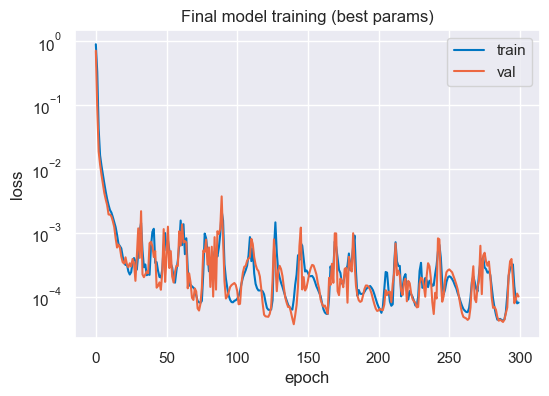

In [17]:
# Train a final model with best params and set it as `model`
activation_map = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "SiLU": nn.SiLU(), "ELU": nn.ELU()}
loss_map = {"L1": nn.L1Loss(), "MSE": nn.MSELoss()}
optimizer_map = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

best = study.best_params
print("Using best params:", best)

model = FNN(
    input_size,
    output_size,
    hidden_features=best["hidden_size"],
    activation_function=activation_map[best["activation"]]
).to(device)

optimizer = optimizer_map[best["optimizer"]](model.parameters(), lr=best["learning_rate"]) 
loss_function = loss_map[best["loss"]]

FINAL_EPOCHS = 300
train_curve, val_curve = [], []
for epoch in range(1, FINAL_EPOCHS + 1):
    tr = train_epoch(model, train_loader, optimizer, loss_function)
    vl = evaluation(model, validation_loader, loss_function)
    train_curve.append(tr)
    val_curve.append(vl)
    if epoch % 20 == 0:
        print(f"final epoch {epoch}: train={tr:.4f}, val={vl:.4f}")

# Optional: quick plot of curves
plt.figure(figsize=(6,4))
plt.plot(train_curve, label="train")
plt.plot(val_curve, label="val")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Final model training (best params)")
plt.legend();